# CatBoost on MalbehavD-V1

Exploring the claims of CatBoost to use categorical data.

# 0. Import Libraries

In [9]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split #For Splitting Datasets
from sklearn import preprocessing #For LabelEncoding
from sklearn.metrics import classification_report #For Classification Report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #For Confusion Matrix
import matplotlib.pyplot as plt #For figure plotting.
from sklearn.model_selection import RandomizedSearchCV #For automated hyperparameter tuning; Would be better if it was GridSearchCV
from sklearn.preprocessing import LabelEncoder
import imblearn
import lightgbm as lgbm
import catboost as catb
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTEN

# 1. Import Dataset

In [2]:
malbd = pd.read_csv("malbd.csv")
malbd

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,ed6a3fc04af435176b9c2f3024eb53c31d1e522da52c5c...,1,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ed5d70a13633a46355c0c2f9905ba29b7b74dfdb4db321...,1,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,ed5addbdbe5f56f108530148c71ab7db806ac9324395d0...,1,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ed4f4518e3120a4fd8ff6c61bf072d4de60264711a9196...,1,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Cleaning Dataset

In [3]:
#Fixing column labels
new_col_name = ['sha256','labels']
for i in range(0,175):
    new_col_name.append(str(i))
malbd.columns = new_col_name

#Removing sha256 column
malbd.drop('sha256', axis=1, inplace=True)

#Fill NaN values with space
malbd.fillna(value=' ', inplace=True)

malbd.head()

,labels,0,1,2,3,4,5,6,7,8,...,165,166,167,168,169,170,171,172,173,174
0,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,...,,,,,,,,,,
1,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,...,,,,,,,,,,
2,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,...,,,,,,,,,,
3,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,,,,,,,,,,
4,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,...,,,,,,,,,,


In [4]:
def label_encoder(df, labels):
    le = LabelEncoder()
    le.fit(labels)
    df_feats = df.iloc[:, 1:].apply(le.fit_transform)
    df.drop(df.columns[1:], axis=1, inplace=True)#
    return df.join(df_feats)

#Label Encoding
uniqueAPI = pd.unique(malbd.columns[1:].values.ravel('K')).tolist()
malbd = label_encoder(malbd, uniqueAPI)
malbd

,labels,0,1,2,3,4,5,6,7,8,...,165,166,167,168,169,170,171,172,173,174
0,0,26,2,66,53,30,32,45,38,64,...,0,0,0,0,0,0,0,0,0,0
1,0,35,19,66,10,79,93,47,2,86,...,0,0,0,0,0,0,0,0,0,0
2,0,14,7,27,36,35,78,95,23,106,...,0,0,0,0,0,0,0,0,0,0
3,0,39,31,36,96,67,44,86,55,63,...,0,0,0,0,0,0,0,0,0,0
4,0,26,23,61,95,105,84,57,54,82,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,1,3,13,2,78,45,14,84,3,44,...,0,0,0,0,0,0,0,0,0,0
2566,1,31,62,40,69,94,84,79,94,72,...,0,0,0,0,0,0,0,0,0,0
2567,1,10,51,2,78,45,32,101,80,86,...,0,0,0,0,0,0,0,0,0,0
2568,1,28,30,91,22,34,45,46,71,86,...,0,0,0,0,0,0,0,0,0,0


# 3. XGBoost

*Only a simple test will be done. No tuning, just running.*

In [5]:
#Splitting datasets to train and test datasets
X,y = malbd.iloc[:,1:],malbd['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [6]:
#Loading CatBoost Classifer as an object
xgbClassifier = xgb.XGBClassifier(n_jobs=-1, learning_rate=0.1, max_leaves=0, n_estimators=1000, tree_method='approx')

#Training model
start = time.time()
xgbClassifier.fit(X_train, y_train)
print("Train Time:", time.time()-start, "seconds")

Train Time: 19.107964277267456 seconds


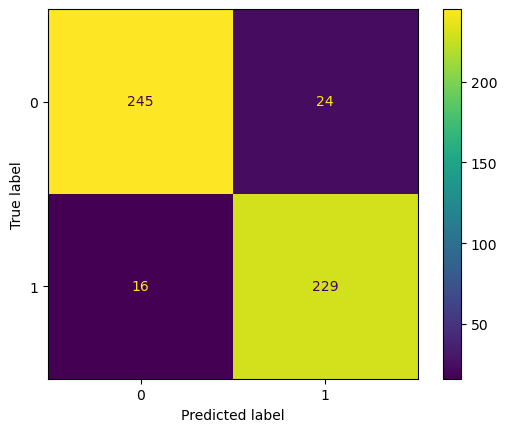

              precision    recall  f1-score   support

           0     0.9387    0.9108    0.9245       269
           1     0.9051    0.9347    0.9197       245

    accuracy                         0.9222       514
   macro avg     0.9219    0.9227    0.9221       514
weighted avg     0.9227    0.9222    0.9222       514



In [7]:
#Testing Predictions
y_pred = xgbClassifier.predict(X_test)

#Create confusion matrix
xgb_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm)
disp.plot()
plt.show()

#Create classification report
xgb_cr = classification_report(y_test, y_pred, digits=4)
print(xgb_cr)